In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [23]:
# Set paths
TRAIN_CSV = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
TEST_CSV = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
TRAIN_PATH = "/kaggle/input/ai-vs-human-generated-dataset/train_data/"
TEST_PATH = "/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/"

# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Check dataset
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print(train_df.head())

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [24]:
# Drop rows with missing values
train_df = train_df.dropna().reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)

print(f"After dropping NaN: Train shape: {train_df.shape}, Test shape: {test_df.shape}")

After dropping NaN: Train shape: (79950, 3), Test shape: (5540, 1)


In [25]:
print(train_df.columns)
print(test_df.columns)

Index(['Unnamed: 0', 'file_name', 'label'], dtype='object')
Index(['id'], dtype='object')


In [26]:
train_df['label'].value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

In [27]:
# Extract image paths and labels correctly
DATASET_PATH = "/kaggle/input/ai-vs-human-generated-dataset"

train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(DATASET_PATH, "train_data", os.path.basename(x)))
test_df["id"] = test_df["id"].apply(lambda x: os.path.join(DATASET_PATH, "test_data_v2", os.path.basename(x)))

# Split into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_df['file_name'].values, train_df['label'].values, test_size=0.2, random_state=42, stratify=train_df['label']
)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

Training samples: 63960, Validation samples: 15990


In [28]:
train_labels = pd.get_dummies(train_labels).astype(int)
val_labels = pd.get_dummies(val_labels).astype(int)

In [29]:
train_labels

,0,1
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
63955,0,1
63956,0,1
63957,1,0
63958,1,0


In [30]:
print("Any NaN in train paths?", pd.isna(train_paths).sum())
print("Any NaN in train labels?", pd.isna(train_labels).sum())

Any NaN in train paths? 0
Any NaN in train labels? 0    0
1    0
dtype: int64


In [31]:
# Image size required for EfficientNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function to load and preprocess images
def load_image(image_path, label=None):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB
    image = tf.image.resize(image, IMG_SIZE)  # Resize to EfficientNet input size
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
    
    # Return (image, label) for training, (image) for test
    return (image, label) if label is not None else image

# Data augmentation function (for training only)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

In [32]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)  # Augment training data
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Datasets prepared successfully!")

Datasets prepared successfully!


In [33]:
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# ResNet-50

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze base

# Build model
model = models.Sequential([
    layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("resnet.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,  # Adjust based on performance
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
import json

# Save history.history dictionary to a JSON file
with open('resnet_training_history.json', 'w') as f:
    json.dump(history.history, f)

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = keras.models.load_model('/kaggle/working/resnet.keras')
y_pred_prob = model.predict(val_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_score = y_pred_prob[:, 1]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step
Accuracy:  0.9687
Precision: 0.9765
Recall:    0.9605
F1-score:  0.9684
AUC-ROC:   0.9958


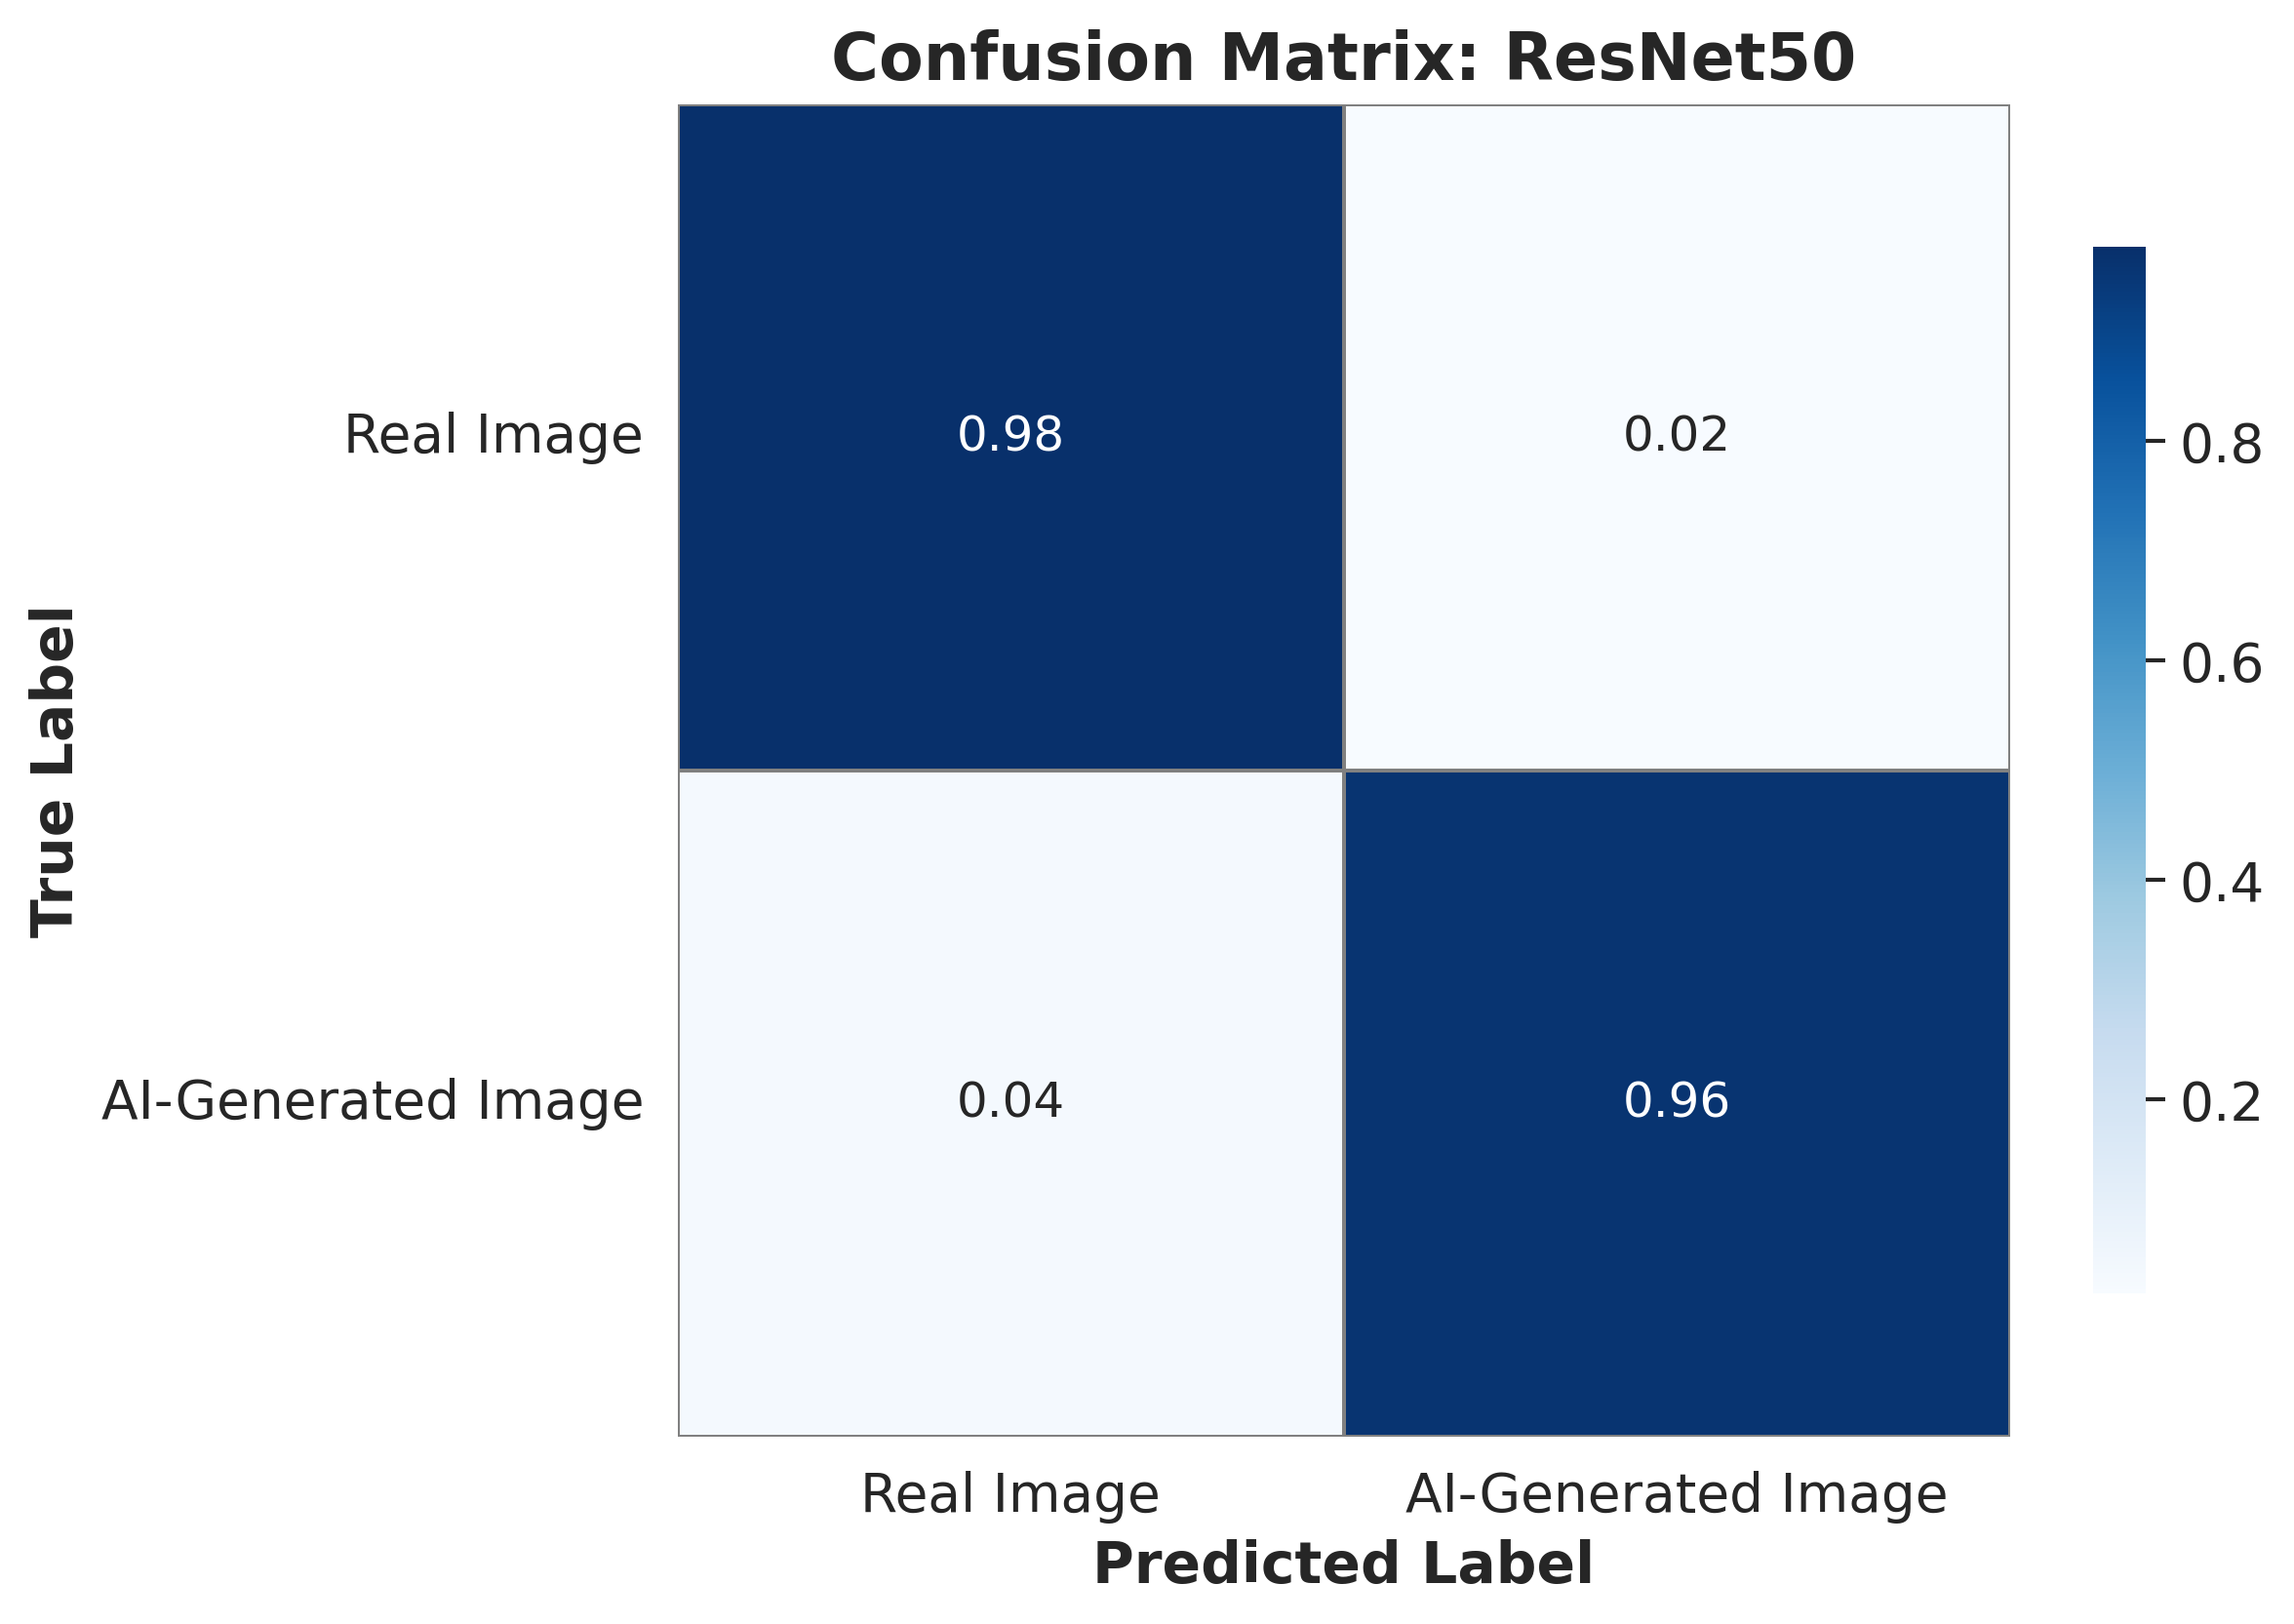

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Class labels
class_names = ['Real Image', 'AI-Generated Image']

# Plotting
plt.figure(figsize=(8, 6), dpi=300)
sns.set(style="white")
sns.set_context("paper", font_scale=1.5)

ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                 linewidths=0.5, linecolor='gray', square=True,
                 cbar_kws={"shrink": 0.75}, annot_kws={"size": 12})

# Labels
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix: ResNet50', fontsize=16, fontweight='bold')
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names, rotation=0)

# Layout
plt.tight_layout()
plt.show()

# ConvNeXtBase

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC

base_model = tf.keras.applications.ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze base

# Build model
model = models.Sequential([
    layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,829,378 (335.04 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("ConvNeXtBase.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,  # Adjust based on performance
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8959 - auc: 0.9549 - loss: 0.2287 - precision: 0.8959 - recall: 0.8959 - val_accuracy: 0.9672 - val_auc: 0.9949 - val_loss: 0.0864 - val_precision: 0.9672 - val_recall: 0.9672
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9792 - auc: 0.9979 - loss: 0.0559 - precision: 0.9792 - recall: 0.9792 - val_accuracy: 0.9764 - val_auc: 0.9971 - val_loss: 0.0634 - val_precision: 0.9764 - val_recall: 0.9764
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9870 - auc: 0.9991 - loss: 0.0358 - precision: 0.9870 - recall: 0.9870 - val_accuracy: 0.9783 - val_auc: 0.9970 - val_loss: 0.0609 - val_precision: 0.9783 - val_recall: 0.9783
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9907 - auc: 0.9995 - loss: 0.0262 - precision: 0.9907 - recall: 0.9907 - val_accuracy: 0.9829 - val_auc: 0.9977 - val_loss: 0.0500 - val_precision: 0.9829 - val_recall: 0.9829
Epoch 5/20
250/250 ━━━━━━━━━

In [16]:
import json

# Save history.history dictionary to a JSON file
with open('convnextbase_training_history.json', 'w') as f:
    json.dump(history.history, f)

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = keras.models.load_model('/kaggle/working/ConvNeXtBase.keras')
y_pred_prob = model.predict(val_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_score = y_pred_prob[:, 1]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 371ms/step
Accuracy:  0.9840
Precision: 0.9774
Recall:    0.9909
F1-score:  0.9841
AUC-ROC:   0.9986


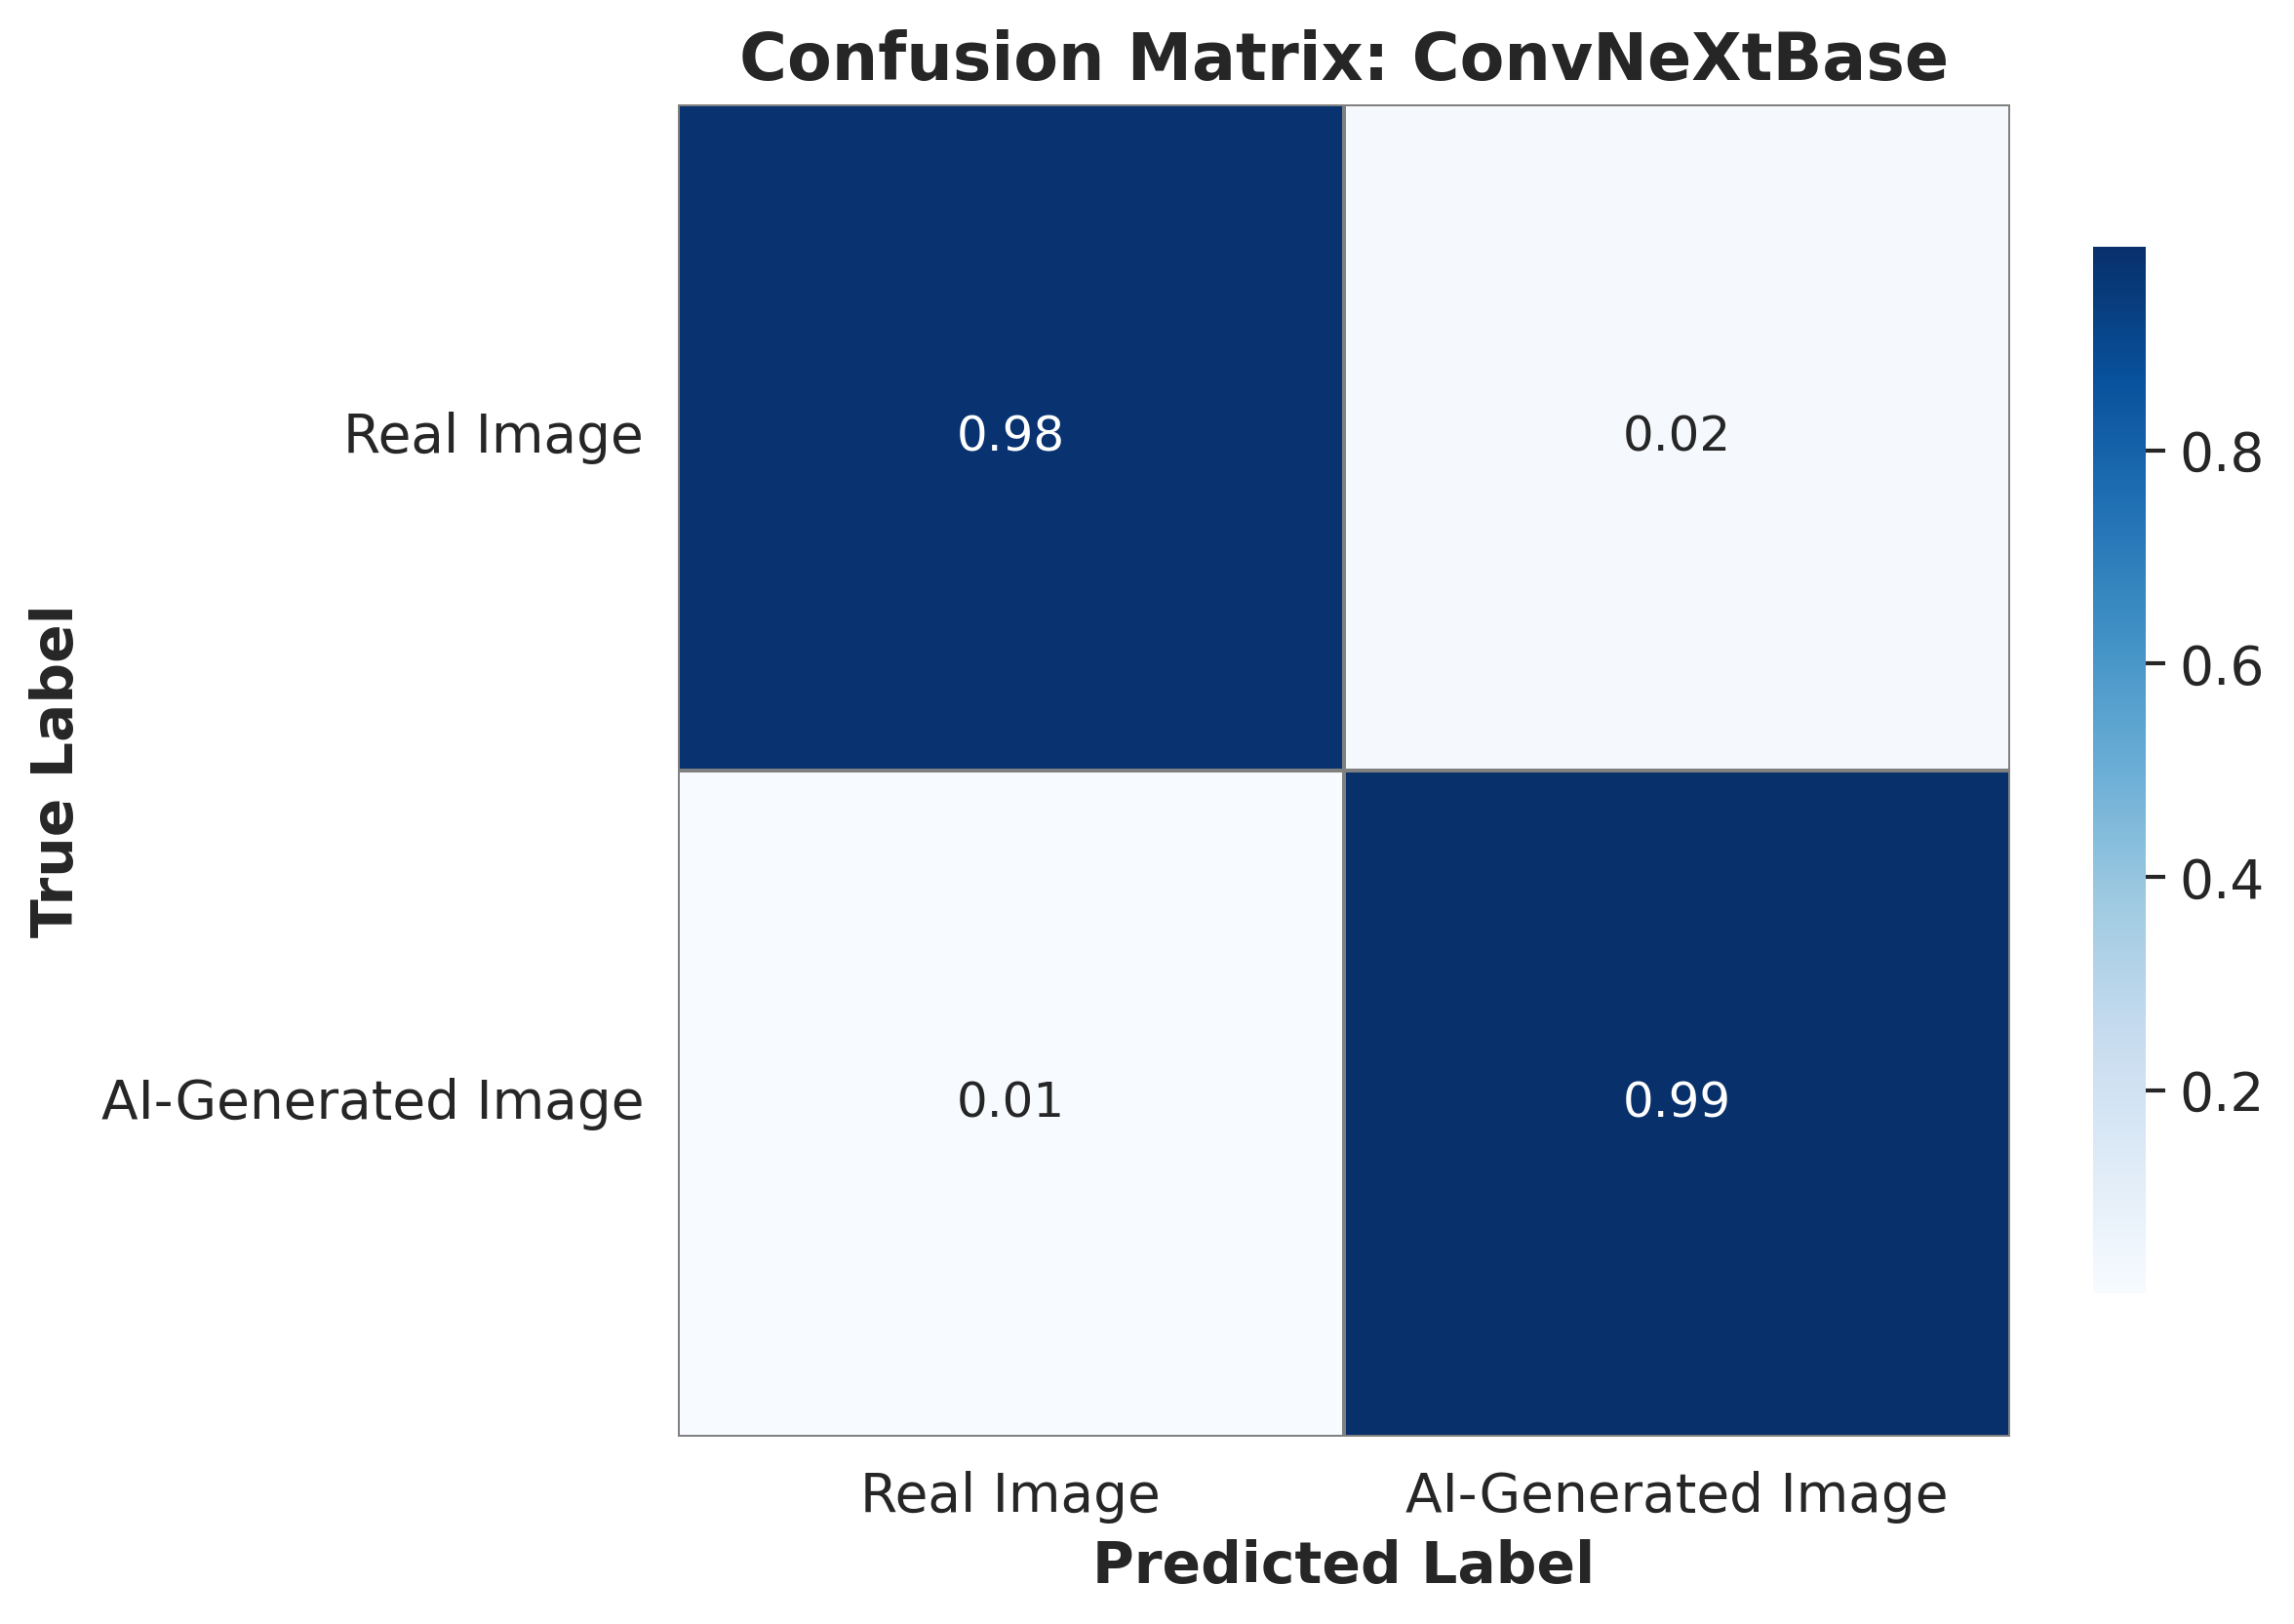

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Class labels
class_names = ['Real Image', 'AI-Generated Image']

# Plotting
plt.figure(figsize=(8, 6), dpi=300)
sns.set(style="white")
sns.set_context("paper", font_scale=1.5)

ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                 linewidths=0.5, linecolor='gray', square=True,
                 cbar_kws={"shrink": 0.75}, annot_kws={"size": 12})

# Labels
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix: ConvNeXtBase', fontsize=16, fontweight='bold')
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names, rotation=0)

# Layout
plt.tight_layout()
plt.show()

# ViT

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

In [41]:
import tf_keras
from tf_keras.metrics import Precision, Recall, AUC

base_model = hub.KerasLayer(
    "https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b8-fe/1",
    trainable = False,
    input_shape = IMG_SIZE + (3,)
)

model = tf_keras.Sequential([
    tf_keras.layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    base_model,
    tf_keras.layers.Dense(256, activation="relu"),
    tf_keras.layers.Dropout(0.3),
    tf_keras.layers.Dense(2, activation="softmax")
])
model.compile(
    optimizer=tf_keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
    loss=tf_keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768)               85807872  
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 86005250 (328.08 MB)
Trainable params: 197378 (771.01 KB)
Non-trainable params: 85807872 (327.33 MB)
_________________________________________________________________


In [ ]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_vit.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
import json

# Save history.history dictionary to a JSON file
with open('vit_training_history.json', 'w') as f:
    json.dump(hist.history, f)

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = tf_keras.models.load_model(
    '/kaggle/working/best_vit.keras',
    custom_objects={'KerasLayer': hub.KerasLayer}
)
y_pred_prob = model.predict(val_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_score = y_pred_prob[:, 1]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

250/250 [==============================] - 423s 2s/step
Accuracy:  0.8652
Precision: 0.8615
Recall:    0.8702
F1-score:  0.8658
AUC-ROC:   0.9395


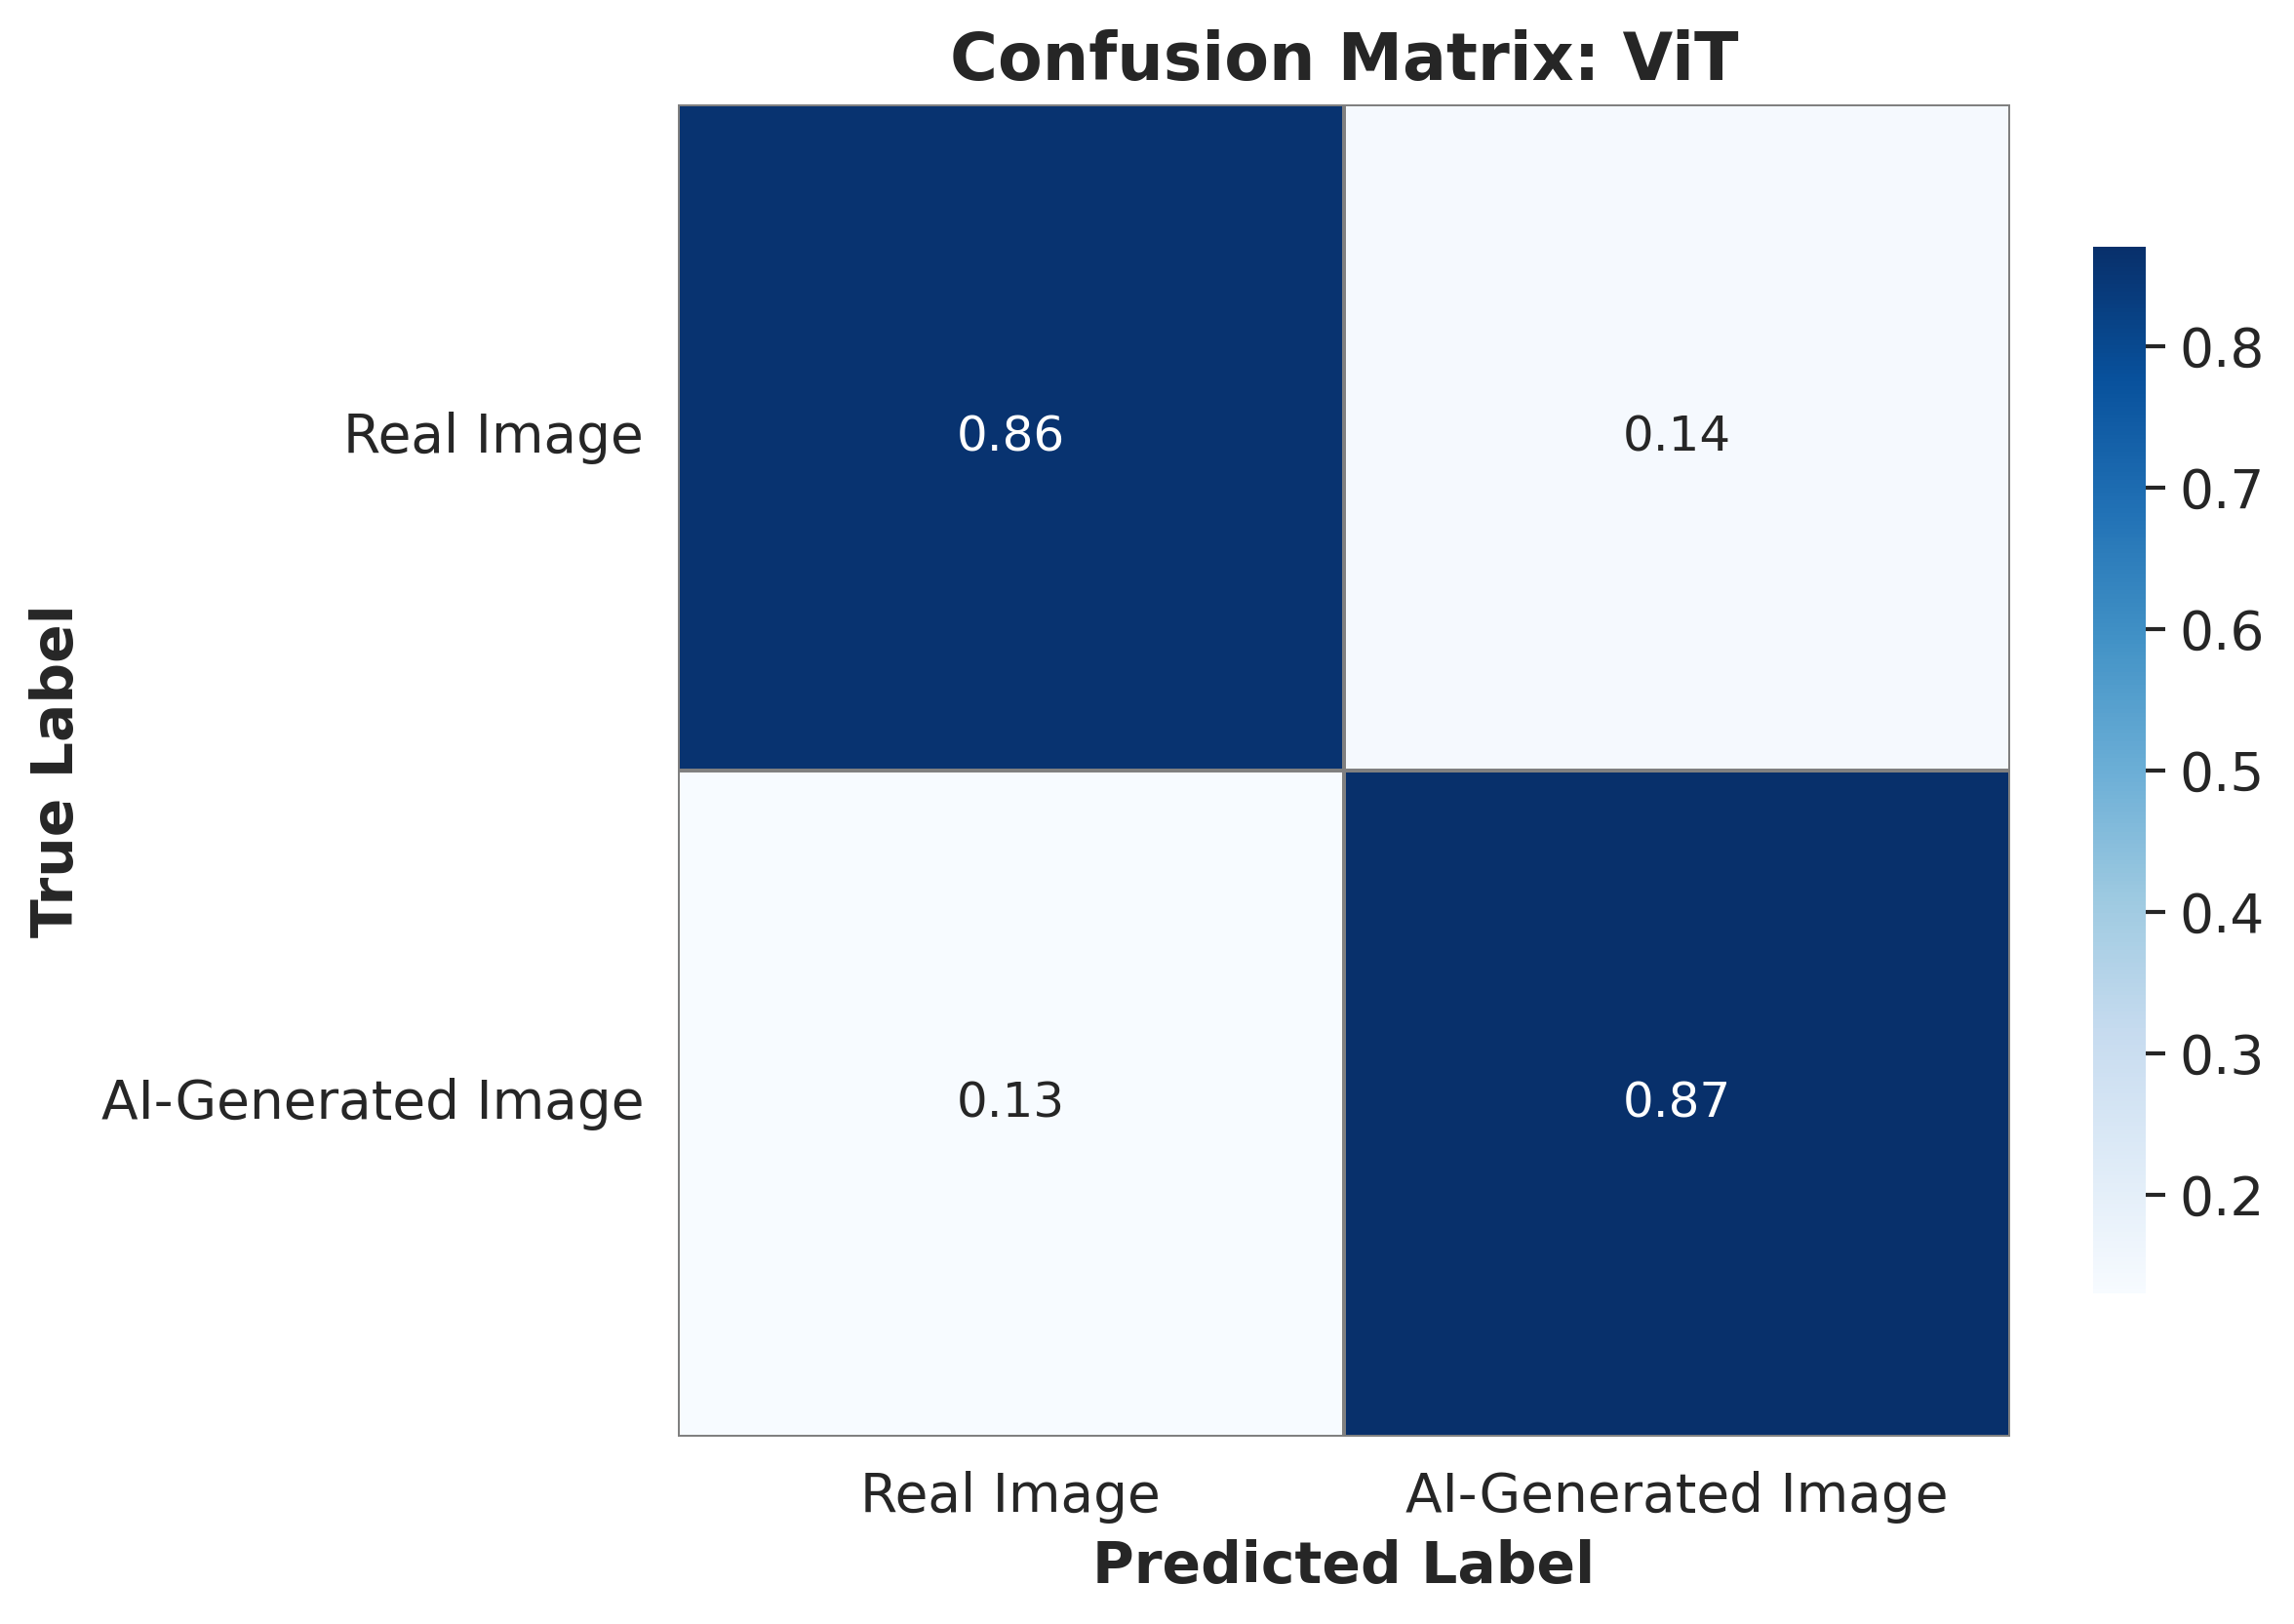

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Class labels
class_names = ['Real Image', 'AI-Generated Image']

# Plotting
plt.figure(figsize=(8, 6), dpi=300)
sns.set(style="white")
sns.set_context("paper", font_scale=1.5)

ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                 linewidths=0.5, linecolor='gray', square=True,
                 cbar_kws={"shrink": 0.75}, annot_kws={"size": 12})

# Labels
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix: ViT', fontsize=16, fontweight='bold')
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names, rotation=0)

# Layout
plt.tight_layout()
plt.show()

# EfficientNetB0

In [45]:
from tensorflow.keras import layers, models

# Load EfficientNetB0 (Pretrained on ImageNet, without top layers)
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Convert feature maps to vector
    layers.Dense(256, activation="relu"),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout to reduce overfitting
    layers.Dense(2, activation="softmax")  # Output layer
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
# Compile the model
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("EfficientNetB0.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,  # Adjust based on performance
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 581ms/step - accuracy: 0.8669 - auc: 0.9408 - loss: 0.2943 - precision: 0.8669 - recall: 0.8669 - val_accuracy: 0.9350 - val_auc: 0.9835 - val_loss: 0.1640 - val_precision: 0.9350 - val_recall: 0.9350
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 429ms/step - accuracy: 0.9299 - auc: 0.9827 - loss: 0.1681 - precision: 0.9299 - recall: 0.9299 - val_accuracy: 0.9452 - val_auc: 0.9875 - val_loss: 0.1418 - val_precision: 0.9452 - val_recall: 0.9452
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 440ms/step - accuracy: 0.9441 - auc: 0.9880 - loss: 0.1393 - precision: 0.9441 - recall: 0.9441 - val_accuracy: 0.9494 - val_auc: 0.9890 - val_loss: 0.1310 - val_precision: 0.9494 - val_recall: 0.9494
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 429ms/step - accuracy: 0.9543 - auc: 0.9913 - loss: 0.1187 - precision: 0.9543 - recall: 0.9543 - val_accuracy: 0.9500 - val_auc: 0.9890 - val_loss: 0.1310 - val_precision: 0.9500 - val_recall: 0.9500
Epoch 5/20
250/2

In [20]:
import json

# Save history.history dictionary to a JSON file
with open('efficientnetb0_training_history.json', 'w') as f:
    json.dump(history.history, f)

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = keras.models.load_model('/kaggle/working/EfficientNetB0.keras')
y_pred_prob = model.predict(val_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_score = y_pred_prob[:, 1]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step
Accuracy:  0.9196
Precision: 0.8690
Recall:    0.9882
F1-score:  0.9248
AUC-ROC:   0.9889


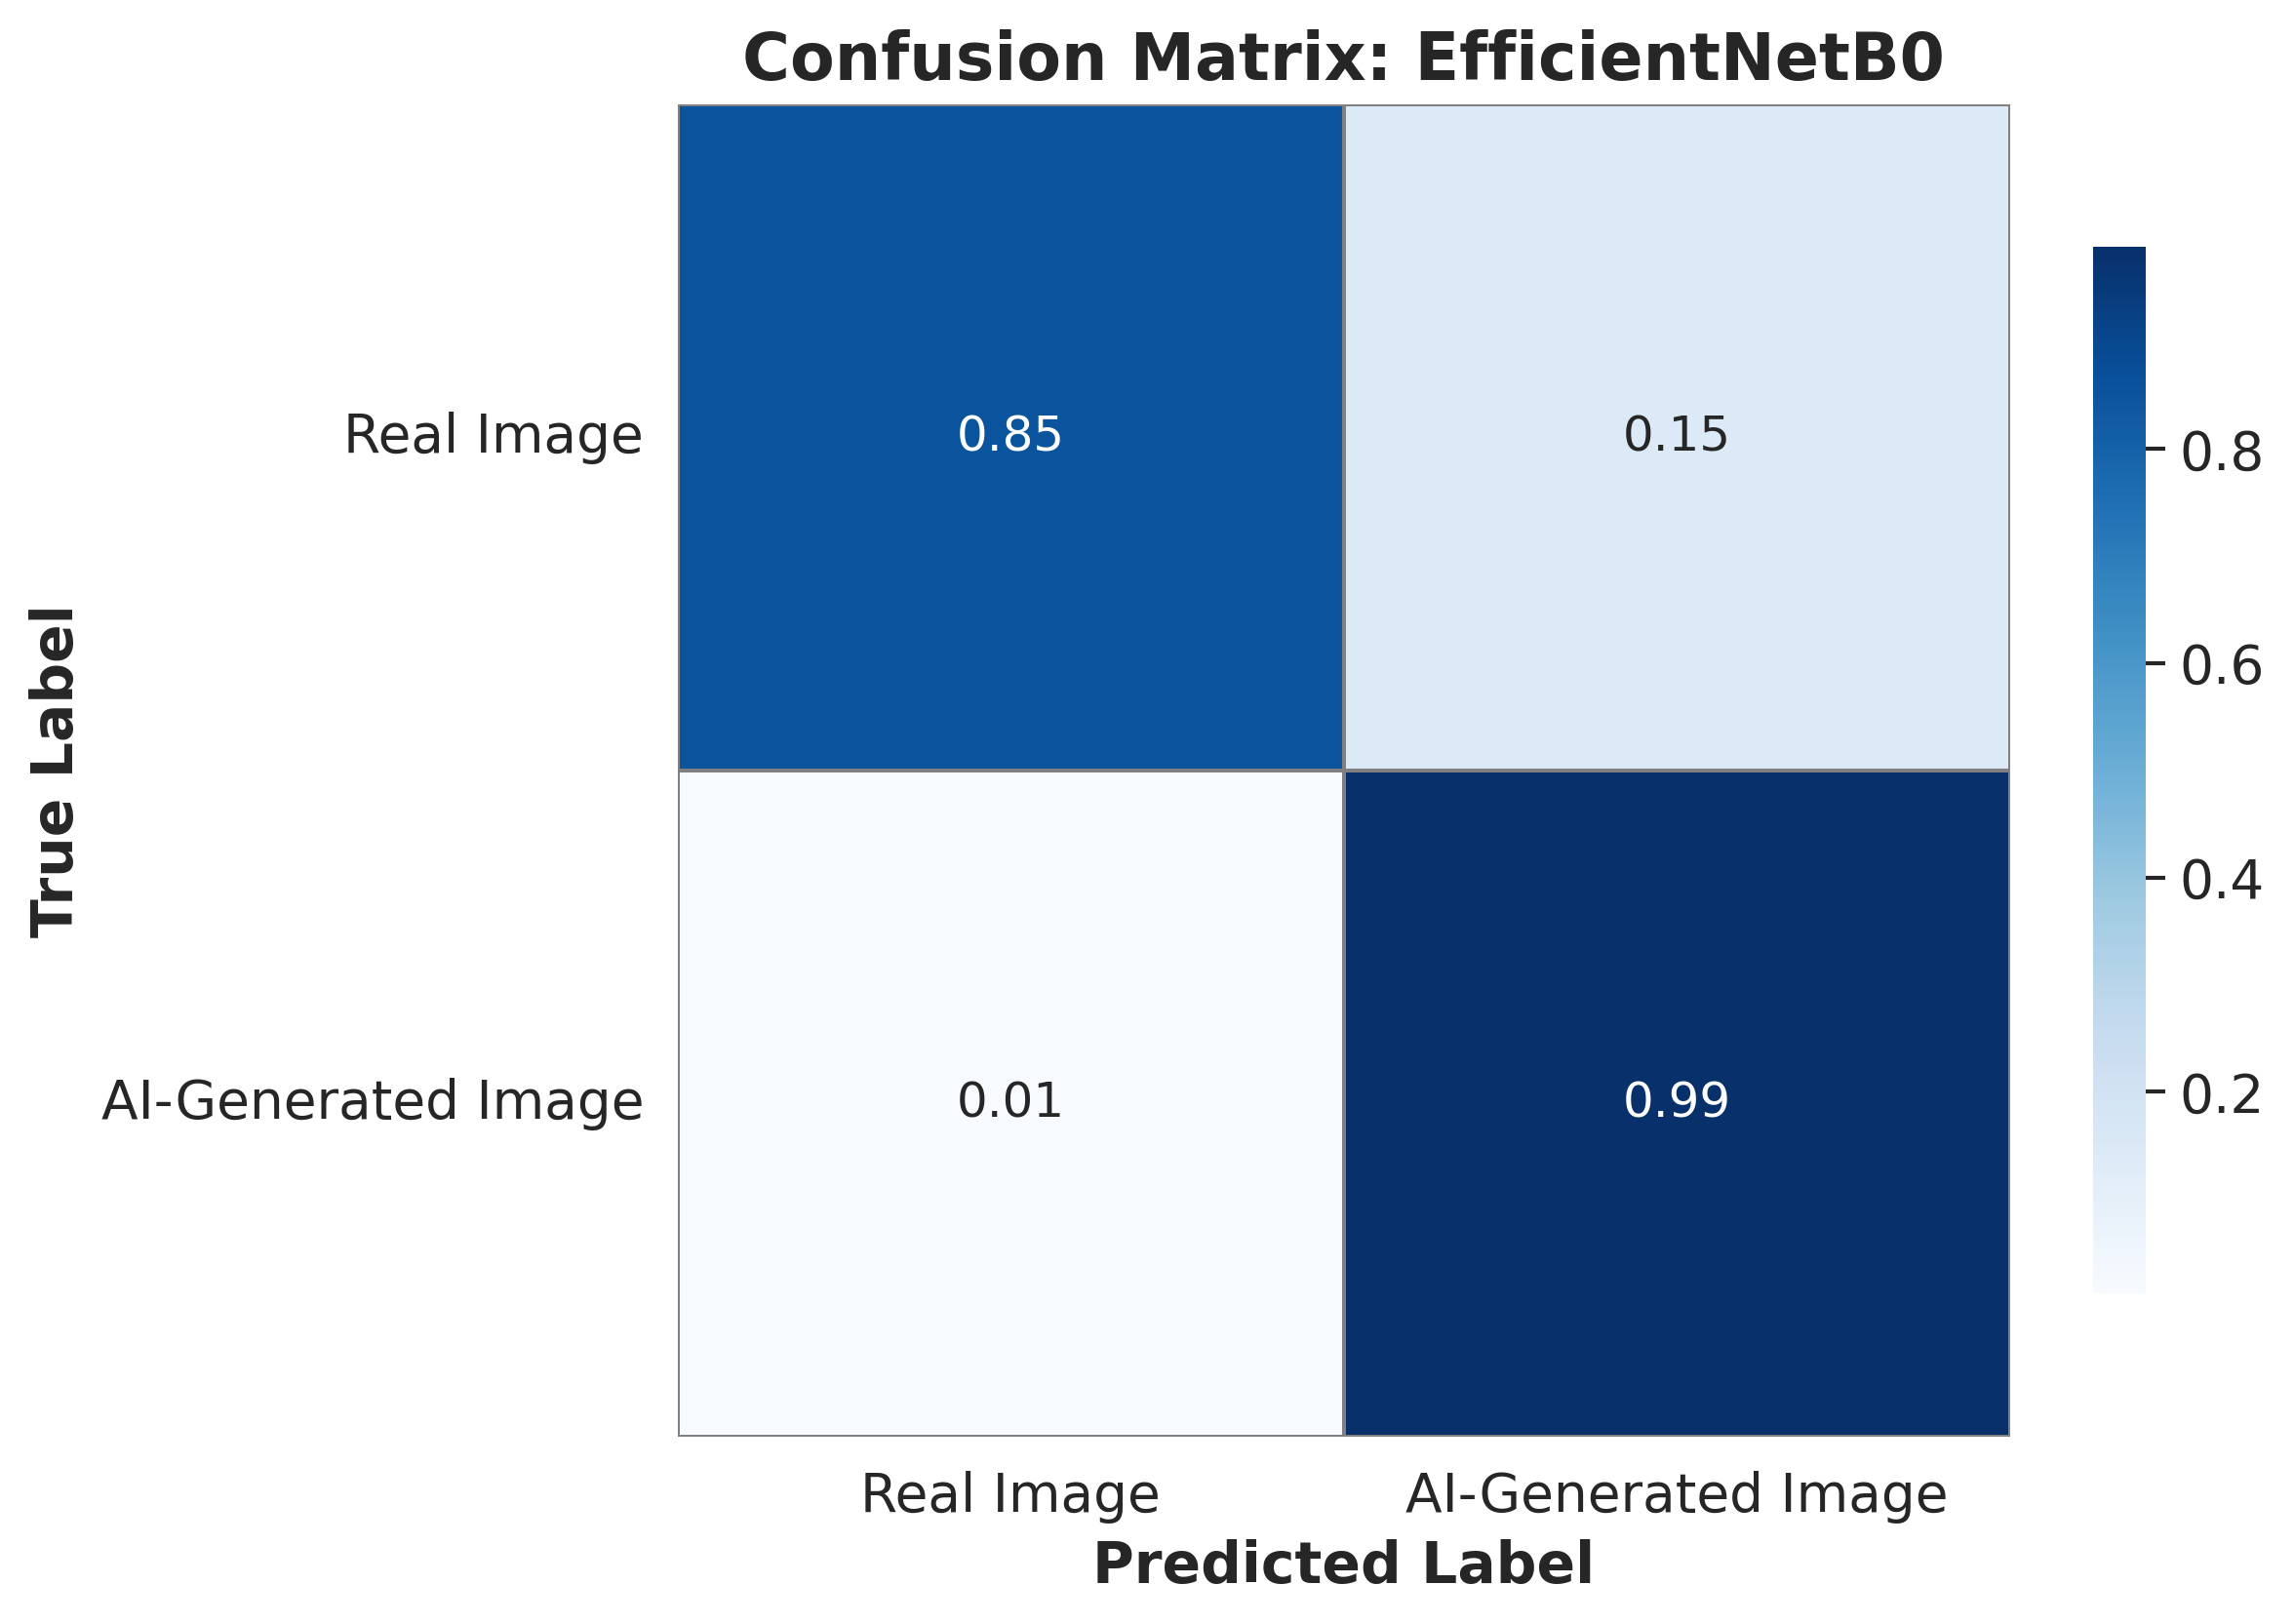

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and normalize confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Class labels
class_names = ['Real Image', 'AI-Generated Image']

# Plotting
plt.figure(figsize=(8, 6), dpi=300)
sns.set(style="white")
sns.set_context("paper", font_scale=1.5)

ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                 linewidths=0.5, linecolor='gray', square=True,
                 cbar_kws={"shrink": 0.75}, annot_kws={"size": 12})

# Labels
ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix: EfficientNetB0', fontsize=16, fontweight='bold')
ax.set_xticklabels(class_names, rotation=0)
ax.set_yticklabels(class_names, rotation=0)

# Layout
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame for easy plotting
history_df = pd.DataFrame(history.history)

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Plot precision Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["precision"], label="Training precision")
plt.plot(history_df["val_precision"], label="Validation precision")
plt.xlabel("Epochs")
plt.ylabel("precision")
plt.legend()
plt.title("precision Curve")
plt.show()

# Plot recall Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["recall"], label="Training recall")
plt.plot(history_df["val_recall"], label="Validation recall")
plt.xlabel("Epochs")
plt.ylabel("recall")
plt.legend()
plt.title("recall Curve")
plt.show()

# Plot auc Curve
plt.figure(figsize=(10, 4))
plt.plot(history_df["auc"], label="Training auc")
plt.plot(history_df["val_auc"], label="Validation auc")
plt.xlabel("Epochs")
plt.ylabel("auc")
plt.legend()
plt.title("auc Curve")
plt.show()

In [ ]:
# Function to load and preprocess test images
def load_test_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
    image = tf.image.resize(image, [224, 224])  # Resize to match EfficientNet input
    image = image / 255.0  # Normalize
    return image

# Load test image paths
test_paths = test_df["id"].values

# Create TensorFlow dataset
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(test_paths[:5])  # Print first 5 paths to verify
print("Any NaN in test paths?", pd.isna(test_paths).sum())

In [ ]:
IMG_SIZE = 224  # Define image size

# Function to load test images (without labels)
def decode_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust if images are PNG
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to model input size
    image = image / 255.0  # Normalize
    return image

# Create a TensorFlow dataset for the test images
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(decode_image).batch(BATCH_SIZE)

print("Test dataset loaded successfully!")

In [ ]:
# Function to load and preprocess images (adjust based on your preprocessing)
def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust for your dataset format
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to model input size
    image = image / 255.0  # Normalize to [0, 1]
    return image, label
    
# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(decode_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Validation dataset loaded successfully!")

In [ ]:
# Get validation predictions
val_predictions = model.predict(val_ds).flatten()  # Ensure 1D array
print(f"Min: {np.min(val_predictions)}, Max: {np.max(val_predictions)}, Mean: {np.mean(val_predictions)}")

In [ ]:
# Compute ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)

# Compute Youden’s J statistic
youden_j = tpr - fpr
optimal_idx = youden_j.argmax()
optimal_threshold = thresholds[optimal_idx]

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold: {optimal_threshold:.4f}", s=100)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line

# Labels and title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve & Optimal Threshold")
plt.legend()
plt.grid()
plt.show()

print(f"Optimal Probability Threshold: {optimal_threshold}")

In [ ]:
from sklearn.metrics import accuracy_score

# accuracy_score(val_labels, val_predictions > 0.5)
[0 if x < 0 else 1 for x in val_predictions]

In [ ]:
# Make predictions
predictions = model.predict(test_ds)
predictions = predictions.flatten()  # Convert to 1D array

print(f"Min: {np.min(predictions)}, Max: {np.max(predictions)}, Mean: {np.mean(predictions)}")

# Apply threshold
predicted_labels = (predictions > np.mean(predictions)).astype(int)
#last tried 0.669708

In [ ]:
predictions

In [ ]:
# How many 0s and 1s are predicted
unique, counts = np.unique(predicted_labels, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
# Create a submission DataFrame
submission = pd.DataFrame({
    "id": test_df["id"].apply(lambda x: "/".join(x.split("/")[-2:])),  # Use actual test IDs from the dataset
    "label": predicted_labels.flatten().astype(int)  # Convert predictions to integers
})

# Save as CSV without index and header
submission.to_csv("/kaggle/working/submission.csv", index=False, encoding="utf-8")

print("Predictions saved to 'submission.csv'")

In [ ]:
df = pd.read_csv("/kaggle/working/submission.csv")
print(df.head())
print(df.dtypes)  # Check if id and label have correct types
df['label'].value_counts()